In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Import Required packages

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import PIL
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow import keras
import glob, os

### Analyzing the shape and distribution of datasets

In [ ]:
partial = glob.glob("/content/MP2_FaceMask_Dataset/train/partial_mask/*")
on = glob.glob("/content/MP2_FaceMask_Dataset/train/with_mask/*")
off = glob.glob("/content/MP2_FaceMask_Dataset/train/without_mask/*")
len(partial), len(on), len(off)

(1294, 1624, 2138)

In [ ]:
total = partial + on + off
len(total)

5056

In [ ]:
height, width  = [],[]
for i in total:
  im = PIL.Image.open(i)
  height.append(np.array(im).shape[0])
  width.append(np.array(im).shape[1])

In [ ]:
print(max(height),min(height), sum(height)/len(height))
print(max(width),min(width),sum(width)/len(width))

4608 141 449.3785601265823
3456 110 434.44026898734177


### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [ ]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,target_size=(224, 224))

validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=50,
                                                         target_size=(224, 224))

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'partial_mask': 0, 'with_mask': 1, 'without_mask': 2}

In [ ]:
next(train_generator)[0].shape

(10, 224, 224, 3)

In [ ]:
input_shap = next(train_generator)[0].shape[1:]
input_shap

(224, 224, 3)

### Visualize the sample images of each class using data generator

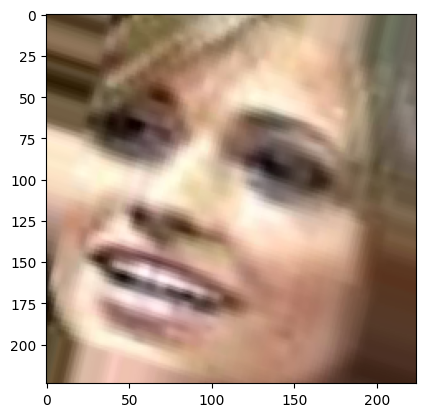

In [ ]:
plt.imshow(next(train_generator)[0][0]);

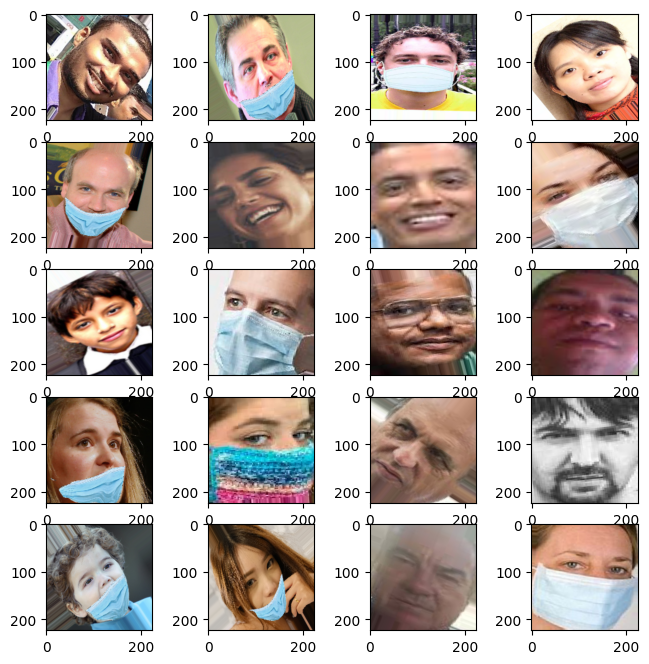

In [ ]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(next(train_generator)[0][0])
plt.show()

## Build the CNN model using Keras



**model 1 with 2 convolutional (feature representation) and 2 maxpool layers (down sampling) and 2 dense layers for classification.**

In [ ]:
model1 = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(input_shap)),            #convolutional layer 1: No. of filters=100, filter size=3x3, activation = relu, input_shap = 224x224x3,
    MaxPooling2D(2,2),                                                          #Maxpooling2D filter size=2x2

    Conv2D(100, (3,3), activation='relu'),                                      #convolutional layer 2: No. of filters=100, filter size=3x3, activation = relu,
    MaxPooling2D(2,2),                                                          #Maxpooling2D filter size=2x2

    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(train_generator.num_classes, activation='softplus')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model1.summary()
#Note: Applying a convolution to an image will make it smaller (if no padding).
#Convolving a 3x3 filter over images means we’ll lose a single pixel on all sides (2 in total).
#In the given case, sliding a 3x3 filter over a 224x224 image results in a 222x222 image

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 100)     90100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 291600)            0         
                                                                 
 dropout (Dropout)           (None, 291600)            0

In [ ]:
history1 = model1.fit(train_generator,epochs=50,validation_data=validation_generator)

Epoch 1/5
503/503 [==============================] - 126s 226ms/step - loss: 0.6964 - acc: 0.5526 - val_loss: 0.4678 - val_acc: 0.8674
Epoch 2/5
503/503 [==============================] - 115s 228ms/step - loss: 0.5225 - acc: 0.8779 - val_loss: 0.5841 - val_acc: 0.8880
Epoch 3/5
503/503 [==============================] - 111s 221ms/step - loss: 0.8440 - acc: 0.7984 - val_loss: 0.5332 - val_acc: 0.8809
Epoch 4/5
503/503 [==============================] - 112s 223ms/step - loss: 0.6285 - acc: 0.5244 - val_loss: 0.6261 - val_acc: 0.4241
Epoch 5/5
503/503 [==============================] - 111s 222ms/step - loss: 0.6260 - acc: 0.4253 - val_loss: 0.6260 - val_acc: 0.4241


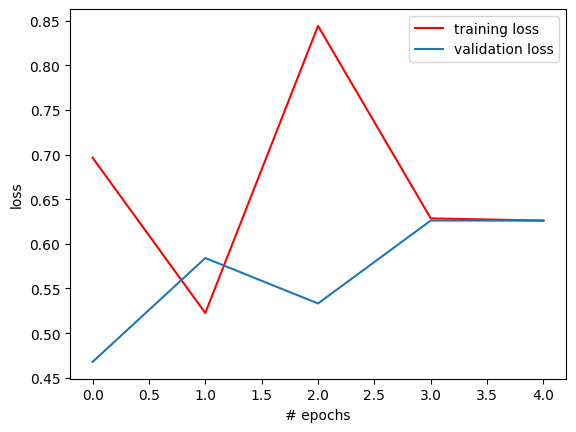

In [ ]:
plt.plot(history1.history['loss'],'r',label='training loss')
plt.plot(history1.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

**model 2 with few more conv layers**

In [ ]:
model2 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(input_shap)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (2,2),activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (2,2),activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(1920, activation='relu'),
    Dense(480, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history2 = model2.fit(train_generator,epochs=50,validation_data=validation_generator)

Epoch 1/5
503/503 [==============================] - 111s 213ms/step - loss: 0.2279 - acc: 0.8660 - val_loss: 0.1651 - val_acc: 0.9102
Epoch 2/5
503/503 [==============================] - 114s 227ms/step - loss: 0.1179 - acc: 0.9431 - val_loss: 0.2767 - val_acc: 0.8483
Epoch 3/5
503/503 [==============================] - 106s 210ms/step - loss: 0.1071 - acc: 0.9467 - val_loss: 0.0982 - val_acc: 0.9587
Epoch 4/5
503/503 [==============================] - 106s 211ms/step - loss: 0.0961 - acc: 0.9576 - val_loss: 0.0852 - val_acc: 0.9658
Epoch 5/5
503/503 [==============================] - 105s 208ms/step - loss: 0.0888 - acc: 0.9600 - val_loss: 0.0833 - val_acc: 0.9651


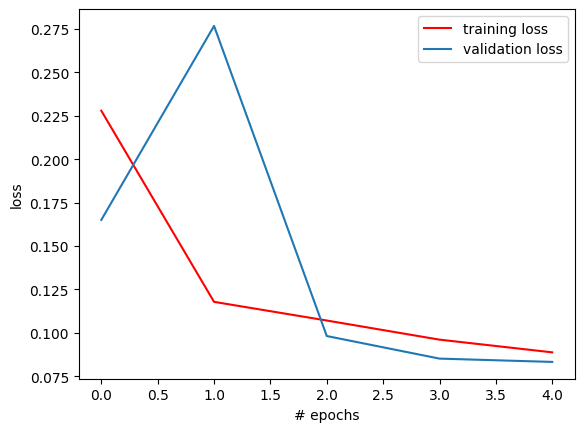

In [ ]:
plt.plot(history2.history['loss'],'r',label='training loss')
plt.plot(history2.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Transfer learning



#### VGG16

In [ ]:
model_vgg = Sequential()
model_vgg.add(VGG16(weights='imagenet',include_top=False,input_shape=(input_shap)))
model_vgg.add(Flatten())
model_vgg.add(Dense(128,activation="relu",kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01)))
model_vgg.add(Dense(train_generator.num_classes,activation='softmax'))
model_vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               3211392   
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17,926,467
Trainable params: 17,926,467
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer_adam = keras.optimizers.Adam(learning_rate=0.00001)
model_vgg.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history3 = model_vgg.fit(train_generator,epochs=5,
                              validation_data=validation_generator, class_weight={0:1.0,1:0.8,2:1.2})

Epoch 1/5
503/503 [==============================] - 153s 285ms/step - loss: 2.3668 - acc: 0.9433 - val_loss: 2.0220 - val_acc: 0.9849
Epoch 2/5
503/503 [==============================] - 151s 301ms/step - loss: 1.8122 - acc: 0.9885 - val_loss: 1.6512 - val_acc: 0.9849
Epoch 3/5
503/503 [==============================] - 131s 260ms/step - loss: 1.4928 - acc: 0.9914 - val_loss: 1.3611 - val_acc: 0.9936
Epoch 4/5
503/503 [==============================] - 132s 262ms/step - loss: 1.2493 - acc: 0.9938 - val_loss: 1.1643 - val_acc: 0.9913
Epoch 5/5
503/503 [==============================] - 132s 261ms/step - loss: 1.0654 - acc: 0.9926 - val_loss: 0.9887 - val_acc: 0.9936


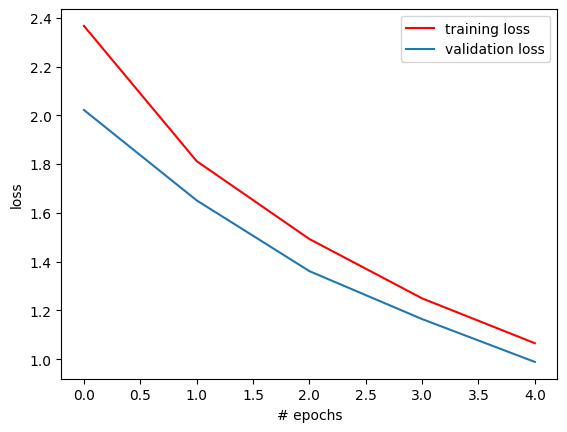

In [ ]:
plt.plot(history3.history['loss'],'r',label='training loss')
plt.plot(history3.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#### ResNet50

In [ ]:
model_resnet = Sequential()
model_resnet.add(ResNet50(weights='imagenet',include_top=False,input_shape=(input_shap)))
model_resnet.add(Flatten())
model_resnet.add(Dense(128))
model_resnet.add(Dense(train_generator.num_classes,activation='softmax'))
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_resnet.build((next(train_generator)[0].shape))
model_resnet.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               12845184  
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 36,433,283
Trainable params: 36,380,163
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
history3 = model_resnet.fit(train_generator,epochs=5,
                    validation_data=validation_generator)

Epoch 1/5
503/503 [==============================] - 188s 296ms/step - loss: 8.1879 - acc: 0.8489 - val_loss: 2.5175 - val_acc: 0.4241
Epoch 2/5
503/503 [==============================] - 125s 249ms/step - loss: 0.7316 - acc: 0.9300 - val_loss: 0.3245 - val_acc: 0.8936
Epoch 3/5
503/503 [==============================] - 125s 248ms/step - loss: 0.4515 - acc: 0.9435 - val_loss: 0.1638 - val_acc: 0.9555
Epoch 4/5
503/503 [==============================] - 145s 288ms/step - loss: 0.3558 - acc: 0.9388 - val_loss: 1.7312 - val_acc: 0.9198
Epoch 5/5
503/503 [==============================] - 125s 249ms/step - loss: 0.3443 - acc: 0.9521 - val_loss: 0.1989 - val_acc: 0.9531


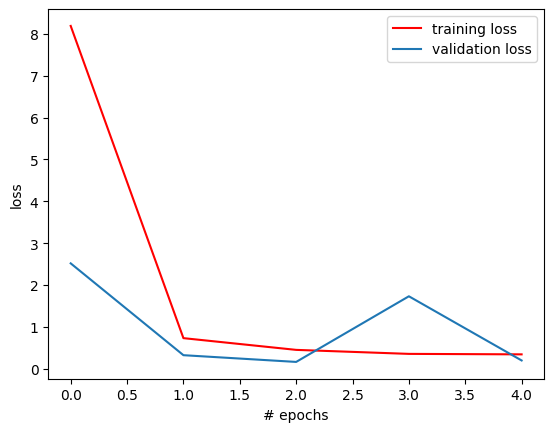

In [ ]:
plt.plot(history3.history['loss'],'r',label='training loss')
plt.plot(history3.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()